# Cliff Walking
https://gymnasium.farama.org/environments/toy_text/cliff_walking

- Observation Space: 48 (4x12 grid)
- Action space: 4 (0: up, 1: right, 2: down, 3: left)

In [2]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt

env = gym.make('CliffWalking-v0')

Visuals

In [3]:
action2str = {
    0: '↑',
    1: '→',
    2: '↓',
    3: '←'
}

def print_policy(p):
    for row in p.reshape(4,12):
        for i in row:
            print(f'{action2str[int(i)]}', end=' ')
        print('\n')
        
def print_state(q):
    for row in q.reshape(4,12):
        for i in row:
            print(f'{i:<.10f}', end=' ')
        print('\n')

def moving_average(data, window_size):
    '''To average the data in case the result varies too much'''
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

def plot_steps(data: dict, x_limit=1000, window_size=10):
    x_limit = x_limit
    window_size = window_size

    # Plotting the results
    plt.figure(figsize=(10, 6))

    # Plot cumulative rewards
    for label, steps in data.items():
        plt.plot(moving_average(steps[:x_limit], window_size), label=label)

    # Set axis limits
    plt.ylim(0, 200)  # Limit the lower bound of y-axis to -1000
    plt.xlim(0, x_limit)   # Limit the x-axis to 1000 episodes

    # Add labels, title, and legend
    plt.xlabel('Episodes')
    plt.ylabel('Steps')
    plt.title(f'Steps Comparison (Window Size = {window_size})')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()
    
def plot_rewards(data: dict, x_limit=1000, window_size=10):
    x_limit = x_limit
    window_size = window_size

    # Plotting the results
    plt.figure(figsize=(10, 6))

    # Plot cumulative rewards
    for label, rewards in data.items():
        plt.plot(moving_average(rewards[:x_limit], window_size), label=label)

    # Set axis limits
    plt.ylim(-1000, 0)  # Limit the lower bound of y-axis to -1000
    plt.xlim(0, x_limit)   # Limit the x-axis to 1000 episodes

    # Add labels, title, and legend
    plt.xlabel('Episodes')
    plt.ylabel('Cumulative Rewards')
    plt.title(f'Cumulative Rewards Comparison (Window Size = {window_size})')
    plt.legend()
    plt.grid(True)
    
    plt.show()

Epsilon Functions
- i starts at 0

#### Epsilon Greedy and GLIE


In [4]:
# The eps function is the result of this function
def eps_anneal(initial, decay_rate, min):
    return lambda i: max(min, initial - (i * decay_rate))

# use directly
def glie(i):
    return 1 / (i+1)

## MC
Policy Evaluation using MC

In [3]:
def MC(gamma=1, n_episodes=10000, alpha=None):
    '''
    Monte Carlo for cliffwalking enviroment
    if alpha = None use Incremental updates
    '''
    V = np.zeros((env.observation_space.n))
    N = np.zeros((env.observation_space.n))
    gamma = gamma
    alpha = alpha
    n_episodes = n_episodes
    total_steps = []
    
    for i in range(n_episodes):
        state = env.reset()[0]  # (36, {'prob': 1})
        history = []
        steps = 0
        
        while True:
            action = env.action_space.sample()
            next_state, reward, terminated, truncated, info = env.step(action)
            history.append((state, reward))
            state = next_state
            steps += 1
            
            if terminated or truncated:
                break
            
        total_steps.append(steps)
        
        cum_reward = 0
        for transition in history[::-1]:
            state, reward = transition
            cum_reward = reward + gamma * cum_reward
            if alpha:
                V[state] = V[state] + alpha*(cum_reward-V[state])
            else: # use Incremental updates
                N[state] += 1
                V[state] += (cum_reward - V[state])/N[state] 
        
        # print progress
        if (i+1)%100 == 0:
            print(f'Episode: {i+1}')
    
    return V, total_steps   

In [4]:
V_MC1, steps_MC1 = MC(alpha=1e-9, n_episodes=1000)
print_state(V_MC1)

Episode: 100
Episode: 200
Episode: 300
Episode: 400
Episode: 500
Episode: 600
Episode: 700
Episode: 800
Episode: 900
Episode: 1000
-28.7416196567 -22.6514229228 -16.0846985926 -10.8584118318 -7.1221634741 -4.6942788407 -2.9814721273 -1.9020608977 -1.2243697882 -0.8094232219 -0.5222253628 -0.3982405059 

-34.7388751986 -23.4842836646 -14.9015347666 -9.4245066586 -5.9122960017 -3.7877311737 -2.4090336809 -1.5490735876 -0.9823189166 -0.6362065180 -0.4136482715 -0.2862502561 

-52.1984038576 -21.6649213266 -10.5945813914 -5.8800710077 -3.5401389263 -2.1878943268 -1.3873682932 -0.9053346807 -0.5920514135 -0.3754881080 -0.2458672318 -0.1301736882 

-100.7462890234 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 



In [5]:
# with low gamma (near sighted)
V_MC2, steps_MC2 = MC(gamma=0.1, alpha=1e-4, n_episodes=500)
print_state(V_MC2)

Episode: 100
Episode: 200
Episode: 300
Episode: 400
Episode: 500
-1.1130734269 -1.1302702927 -1.1311188441 -1.1309714554 -1.1264552253 -1.1065182131 -1.0355307213 -0.9029485155 -0.7413002189 -0.5927550308 -0.4655936202 -0.4005503338 

-1.1614863934 -1.7985858509 -1.8444695858 -1.8133364564 -1.7882124725 -1.7523064039 -1.5742804911 -1.3735675597 -1.0469458522 -0.8065609043 -0.5938889063 -0.3395846316 

-2.4737772959 -27.2351644320 -28.0381555310 -27.5192260743 -26.5079206493 -23.1845612425 -18.9490609753 -15.0053252251 -10.6217633617 -7.6537818399 -5.5534226548 -0.3208388769 

-27.3668555695 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 



### MC Control
Policy Improvement using MC


In [5]:
def MC_Control(gamma=1, n_episodes=1000, epsilon_func=glie, alpha=None):
    '''
    Monte Carlo for cliffwalking enviroment with MC control
    if alpha = None use Incremental updates
    '''
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    N = np.zeros((env.observation_space.n, env.action_space.n))
    gamma = gamma
    alpha = alpha
    n_episodes = n_episodes
    total_steps = []
    total_rewards = []
    
    
    for i in range(n_episodes):
        state = env.reset()[0]  # (36, {'prob': 1})
        history = []
        steps = 0
        epsilon = epsilon_func(i)

        while True:
            # select action (epsilon greedy policy)
            coin = random.random()
            if coin < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])
                
            next_state, reward, terminated, truncated, info = env.step(action)
            history.append((state, action, reward))
            state = next_state
            steps += 1
            
            if terminated or truncated:
                break
        total_steps.append(steps)
        
        cum_reward = 0
        for transition in reversed(history):
            state, action, reward = transition
            cum_reward = reward + gamma * cum_reward
            if alpha:
                Q[state, action] = Q[state, action] + alpha*(cum_reward - Q[state, action])
            else:
                N[state, action] += 1
                Q[state, action] += (cum_reward - Q[state, action])/N[state, action] 
        
        total_rewards.append(cum_reward)        
                
        # print progress
        if (i+1)%1000 == 0:
            print(f'Episode: {i+1}')          
                
    policy = np.argmax(Q, axis=1)

    return policy, Q, total_steps, total_rewards

In [6]:
policy_MC3, Q_MC3, steps_MC3, rewards_MC3 = MC_Control(alpha=1e-8, n_episodes=5000, epsilon_func=eps_anneal(0.9, 0.001, 0.1))
print_policy(policy_MC3)

Episode: 1000
Episode: 2000
Episode: 3000
Episode: 4000
Episode: 5000
→ → → → → → → → → → → ↓ 

↑ ← → → → → → → ↑ → → ↓ 

↑ ↑ ↑ → ↑ ↑ → ↑ → → → ↓ 

↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ 



In [7]:
policy_MC4, Q_MC4, steps_MC4, rewards_MC4 = MC_Control(alpha=1e-8, n_episodes=5000, epsilon_func=eps_anneal(0.9, 0.01, 0.1))
print_policy(policy_MC4)

Episode: 1000
Episode: 2000
Episode: 3000
Episode: 4000
Episode: 5000
↑ → ← → → → → → → → → ↓ 

→ → ↓ → ↑ ← ← → → ↑ → ↓ 

↑ ↑ ↑ → ↓ → ← → ↑ → ↑ ↓ 

↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ 



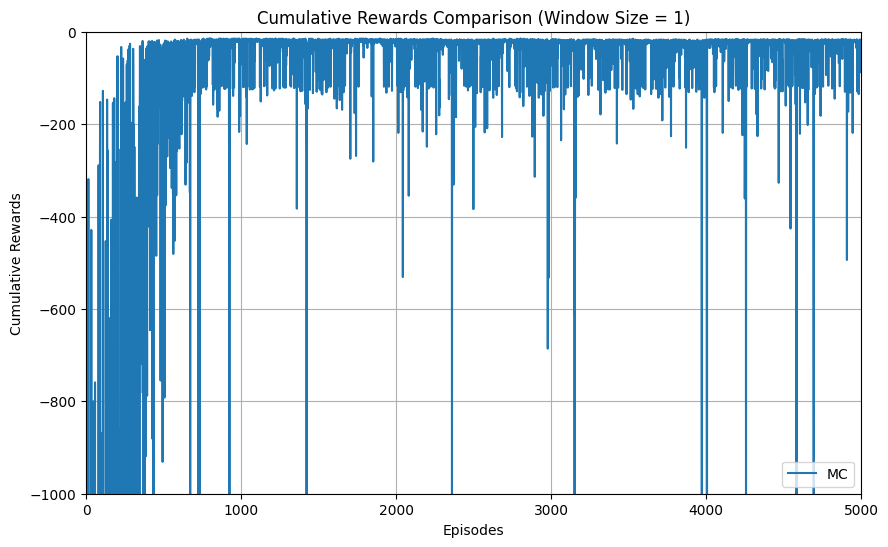

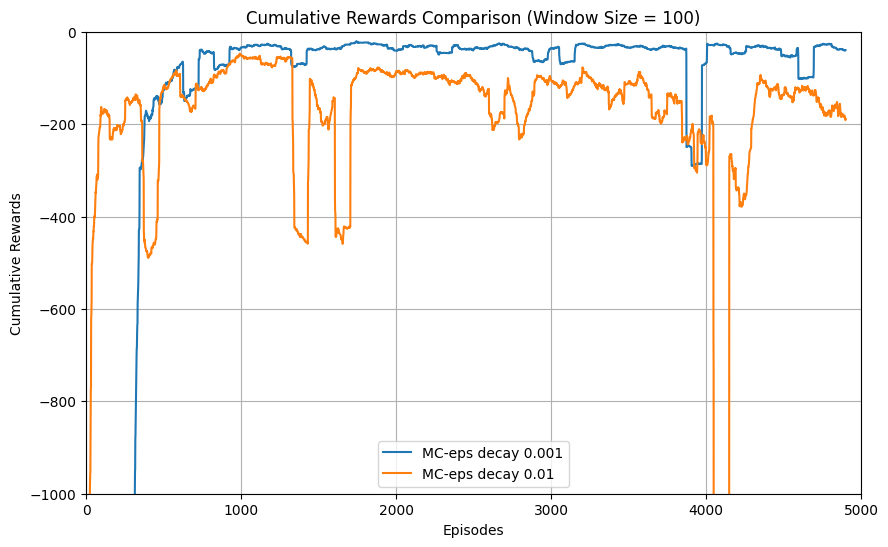

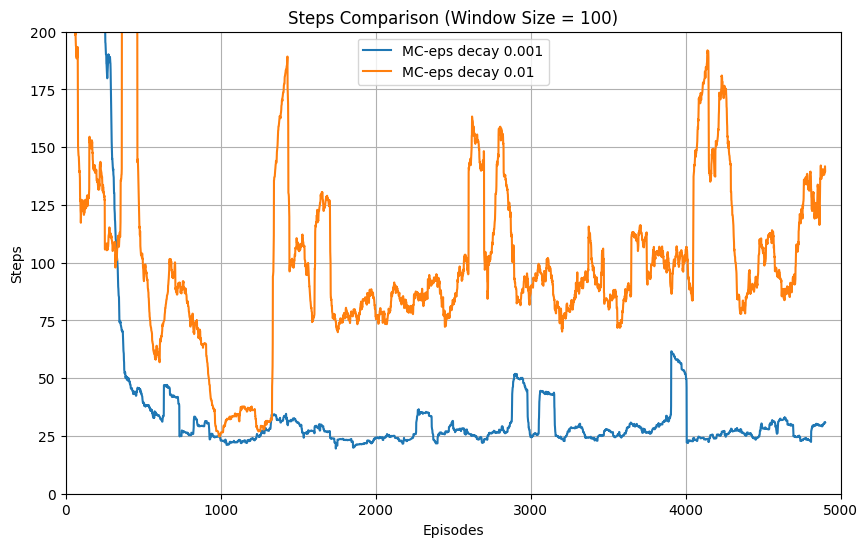

In [80]:
data_MC_reward = {
    'MC-eps decay 0.001': rewards_MC3,
    'MC-eps decay 0.01': rewards_MC4,
}

data_MC_steps = {
    'MC-eps decay 0.001': steps_MC3,
    'MC-eps decay 0.01': steps_MC4,
}

plot_rewards({'MC': rewards_MC3}, x_limit=5000, window_size=1)
plot_rewards(data_MC_reward, x_limit=5000, window_size=100)
plot_steps(data_MC_steps, x_limit=5000, window_size=100)

## TD
Policy Evaluation Using TD


In [8]:
def TD(gamma=1, n_episodes=10000, alpha=0.001):
    V = np.zeros((env.observation_space.n))
    N = np.zeros((env.observation_space.n))
    gamma = gamma
    alpha = alpha
    n_episodes = n_episodes
    total_steps = []
    
    for i in range(n_episodes):
        state = env.reset()[0]  # (36, {'prob': 1})
        steps = 0
        
        while True:
            action = env.action_space.sample()
            next_state, reward, terminated, truncated, info = env.step(action)
            if alpha:
                V[state] += alpha*(reward+gamma*V[next_state] - V[state])
            state = next_state
            steps += 1
            
            if terminated or truncated:
                break
            
        total_steps.append(steps)
        
        # print progress
        if (i+1)%100 == 0:
            print(f'Episode: {i+1}')

    return V, total_steps

In [9]:
V_TD1, steps_TD1 = TD(alpha=1e-5, n_episodes=500)
print_state(V_TD1)

Episode: 100
Episode: 200
Episode: 300
Episode: 400
Episode: 500
-3.7187270868 -2.9360977723 -1.7431796096 -1.0065942712 -0.6217255111 -0.3922899379 -0.2582980015 -0.1677689618 -0.1093371212 -0.0766750305 -0.0567165507 -0.0467431190 

-11.3617849354 -9.6855234951 -5.0042873525 -2.2922001615 -1.0886460090 -0.5649556923 -0.3101010463 -0.1808978820 -0.1056538334 -0.0702943591 -0.0510341810 -0.0376527659 

-43.6935748134 -48.3972654865 -31.0807555780 -18.7011651982 -11.3093353465 -7.3474992412 -4.7997682288 -3.1653338012 -1.9788569141 -1.4335040064 -1.0949130280 -0.0229851887 

-112.9541686067 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 



### Sarsa


In [41]:
def SARSA(gamma=1, n_episodes=10000, alpha=0.01, epsilon_func=glie):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    gamma = gamma
    alpha = alpha
    n_episodes = n_episodes
    total_steps = []
    total_rewards = []
    
    for i in range(n_episodes):
        state = env.reset()[0]  # (36, {'prob': 1})
        steps = 0
        cum_reward = 0
        epsilon=epsilon_func(i)
        
        while True:
            coin = random.random()
            if coin < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_state, reward, terminated, truncated, info = env.step(action)
            cum_reward += reward
            
            # next action with same policy
            coin = random.random()
            if coin < epsilon:
                next_action = env.action_space.sample()
            else:
                next_action = np.argmax(Q[state])
                
            Q[state, action] = Q[state, action] + alpha*(reward + gamma*(Q[next_state, next_action])-Q[state, action])

            state = next_state
            steps += 1
            
            if terminated or truncated:
                break
        total_rewards.append(cum_reward)    
        total_steps.append(steps)  
                
    policy = np.argmax(Q, axis=1)

    return policy, Q, total_steps, total_rewards

In [108]:
policy_SARSA, Q_SARSA, steps_SARSA, rewards_SARSA = SARSA(n_episodes=5000, alpha=0.01, epsilon_func=eps_anneal(0.9, 0.01, 0.01))
print_policy(policy_SARSA)

↑ ← → → ↓ → → → → → → ↓ 

→ → → → → → → → → → → ↓ 

↑ ↑ ↑ → → → → → ← → ← ↓ 

↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ 



In [82]:
policy_SARSA2, Q_SARSA2, steps_SARSA2, rewards_SARSA2 = SARSA(gamma=0.9, n_episodes=5000, alpha=0.01, epsilon_func=eps_anneal(0.9, 0.001, 0.1))
print_policy(policy_SARSA2)

→ ← → → → → ↑ → → → → ↓ 

→ → → → → → → → → → → ↓ 

↑ ↑ → ↑ ↑ → → ↑ ← ← → ↓ 

↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ 



In [23]:
policy_SARSAg, Q_SARSAg, steps_SARSAg, rewards_SARSAg = SARSA(n_episodes=5000, alpha=0.01)
print_policy(policy_SARSAg)

← ← → ↑ → ← → → ← → ← ↓ 

↑ → → → → → → → → → → ↓ 

→ → → → → → → → → → → ↓ 

↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ 



In [89]:
policy_SARSAg2, Q_SARSAg2, steps_SARSAg2, rewards_SARSAg2 = SARSA(gamma=0.9, n_episodes=5000, alpha=0.01)
print_policy(policy_SARSAg2)

↓ ↓ → → → ↑ → ↑ ↓ ← ↓ ↓ 

↑ ↑ → → ← → → → → → → ↓ 

→ → → → → → → → → → → ↓ 

↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ 



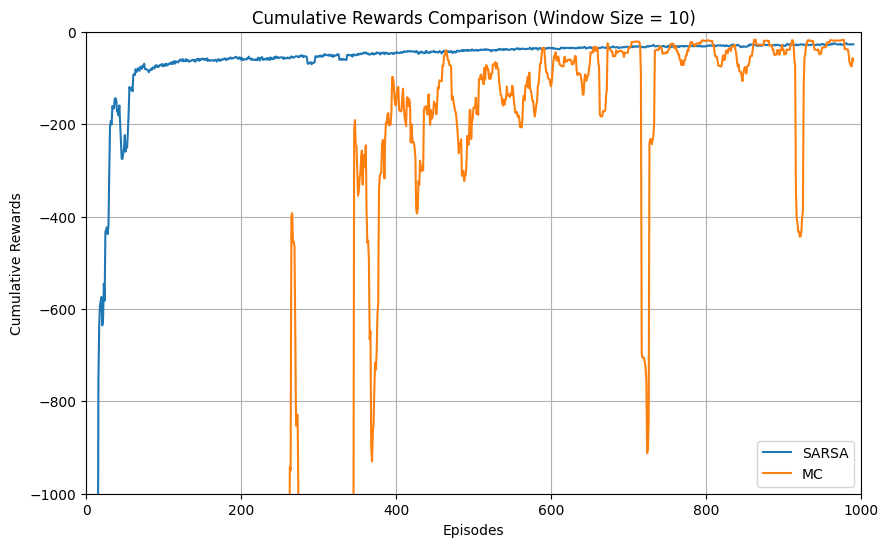

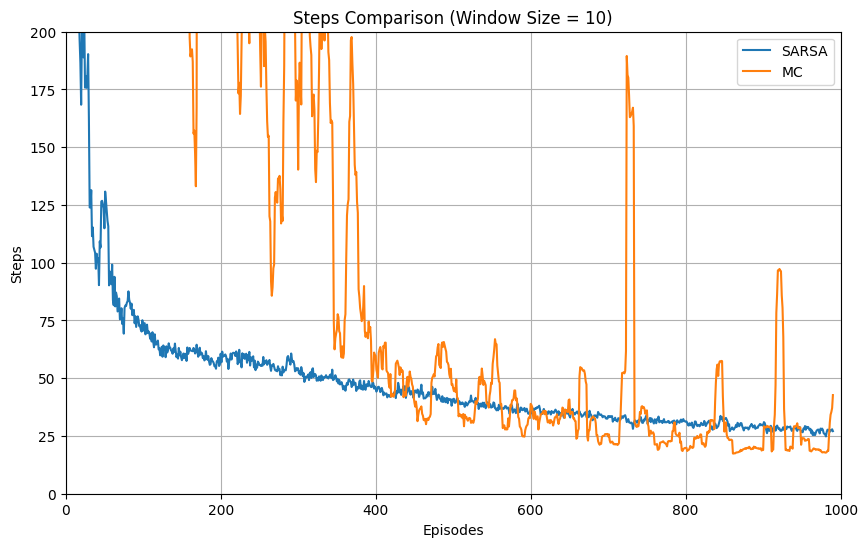

In [109]:
data_SARSA_reward = {
    'SARSA': rewards_SARSA,
    'MC': rewards_MC3
}

data_SARSA_steps = {
    'SARSA': steps_SARSA,
    'MC': steps_MC3
}

plot_rewards(data_SARSA_reward, x_limit=1000, window_size=10)
plot_steps(data_SARSA_steps, x_limit=1000, window_size=10)

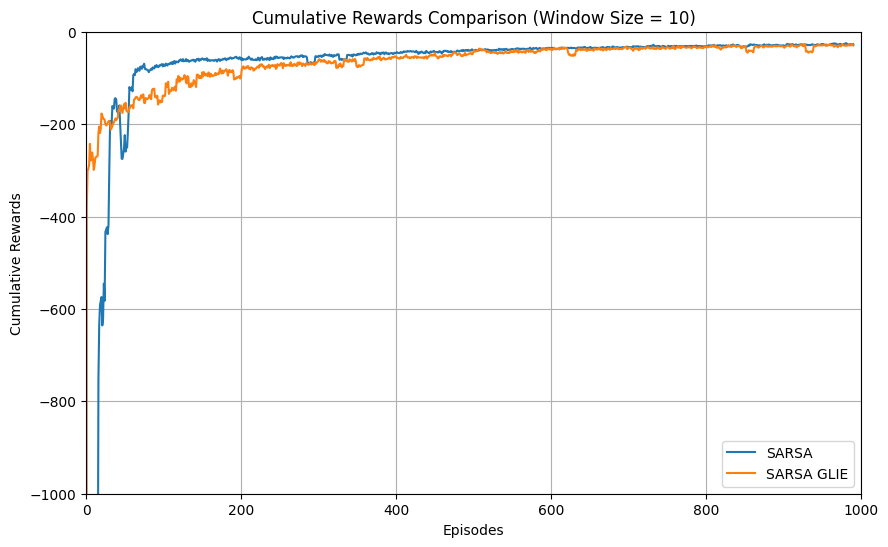

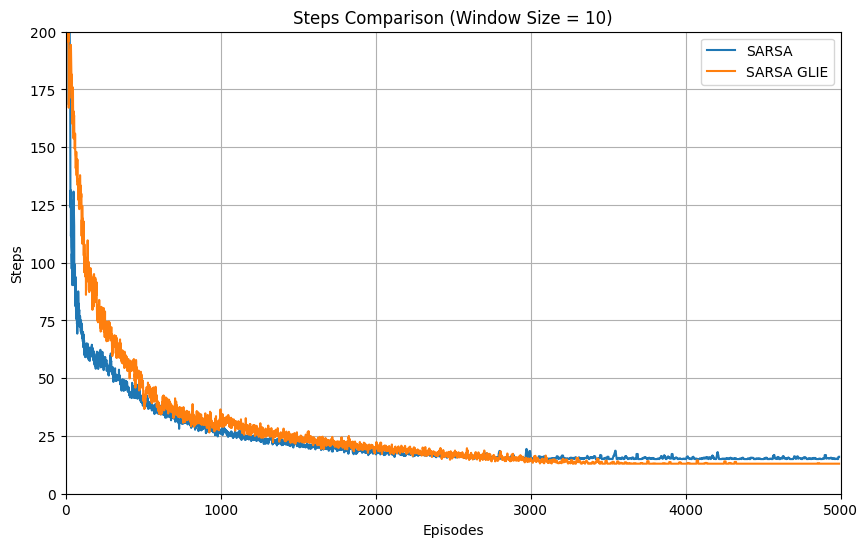

In [111]:
data_SARSA_reward = {
    'SARSA': rewards_SARSA,
    # 'SARSA gamma 0.9': rewards_SARSA2,
    'SARSA GLIE': rewards_SARSAg,
    # 'SARSAg gamma 0.9': rewards_SARSAg2,
}

data_SARSA_steps = {
    'SARSA': steps_SARSA,
    # 'SARSA gamma 0.9': steps_SARSA2,
    'SARSA GLIE': steps_SARSAg,
    # 'SARSAg gamma 0.9': steps_SARSAg2,
}

plot_rewards(data_SARSA_reward, x_limit=1000, window_size=10)
plot_steps(data_SARSA_steps, x_limit=5000, window_size=10)

#### SARSA with Eligibility Trace

In [33]:
def SARSA_lambda(gamma=1, n_episodes=10000, alpha=0.01, epsilon_func=glie, _lambda = 0.9):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    E = np.zeros((env.observation_space.n, env.action_space.n))
    gamma = gamma
    alpha = alpha
    _lambda = _lambda
    n_episodes = n_episodes
    total_steps = []
    total_rewards = []
    
    for i in range(n_episodes):
        state = env.reset()[0]  # (36, {'prob': 1})
        steps = 0
        cum_reward = 0
        epsilon=epsilon_func(i)
        
        while True:
            coin = random.random()
            if coin < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_state, reward, terminated, truncated, info = env.step(action)
            cum_reward += reward
            
            # next action with same policy
            coin = random.random()
            if coin < epsilon:
                next_action = env.action_space.sample()
            else:
                next_action = np.argmax(Q[state])
                
            td_error = reward + gamma*(Q[next_state, next_action])-Q[state, action]
            E[state, action] = E[state, action] + 1
            
            for s in range(env.observation_space.n):
                for a in range(env.action_space.n):
                    Q[state, action] = Q[state, action] + alpha*(td_error)*E[state, action]
                    E[state, action] = gamma * _lambda * E[state, action]

            state = next_state
            steps += 1
            
            if terminated or truncated:
                break
        total_rewards.append(cum_reward)    
        total_steps.append(steps)  
                
    policy = np.argmax(Q, axis=1)

    return policy, Q, total_steps, total_rewards

In [117]:
policy_SARSAl, Q_SARSAl, steps_SARSAl, rewards_SARSAl = SARSA_lambda(n_episodes=5000, alpha=0.01)
print_policy(policy_SARSAl)

→ → → → → → → → → → → ↓ 

↑ ↑ → → → → → → → → → ↓ 

↑ → ↑ ↑ ↑ ↑ ← ↑ ↑ → → ↓ 

↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ 



In [46]:
policy_SARSAl2, Q_SARSAl2, steps_SARSAl2, rewards_SARSAl2 = SARSA_lambda(n_episodes=5000, alpha=0.01, _lambda=0.5)
print_policy(policy_SARSAl2)

← → → → → → ↓ ↓ → ↓ → ↓ 

→ → → → → → → → → → → ↓ 

→ → → → → → → → → → → ↓ 

↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ 



In [47]:
policy_SARSAl3, Q_SARSAl3, steps_SARSAl3, rewards_SARSAl3 = SARSA_lambda(n_episodes=5000, alpha=0.01, _lambda=0.1)
print_policy(policy_SARSAl3)

→ ← ↑ ↑ ↓ → → ↓ → ↑ ↑ ↓ 

↑ ← → → → → → → → → → ↓ 

→ → → → → → → → → → → ↓ 

↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ 



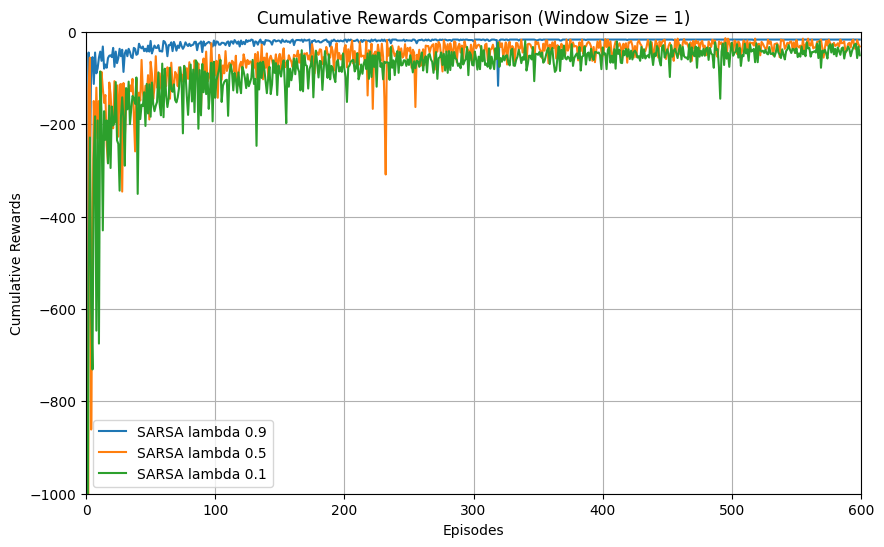

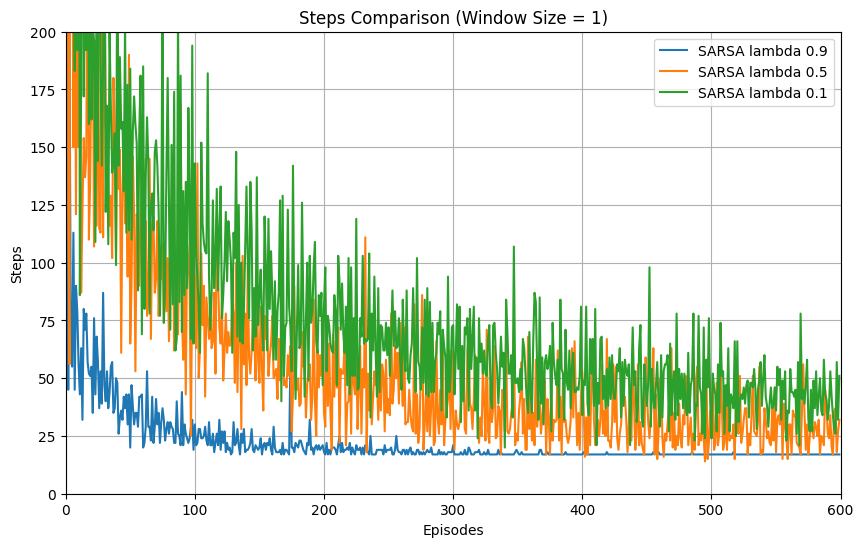

In [118]:
data_SARSAl_reward = {
    'SARSA lambda 0.9': rewards_SARSAl,
    'SARSA lambda 0.5': rewards_SARSAl2,
    'SARSA lambda 0.1': rewards_SARSAl3,
}

data_SARSAl_steps = {
    'SARSA lambda 0.9': steps_SARSAl,
    'SARSA lambda 0.5': steps_SARSAl2,
    'SARSA lambda 0.1': steps_SARSAl3,
}

plot_rewards(data_SARSAl_reward, x_limit=600, window_size=1)
plot_steps(data_SARSAl_steps, x_limit=600, window_size=1)

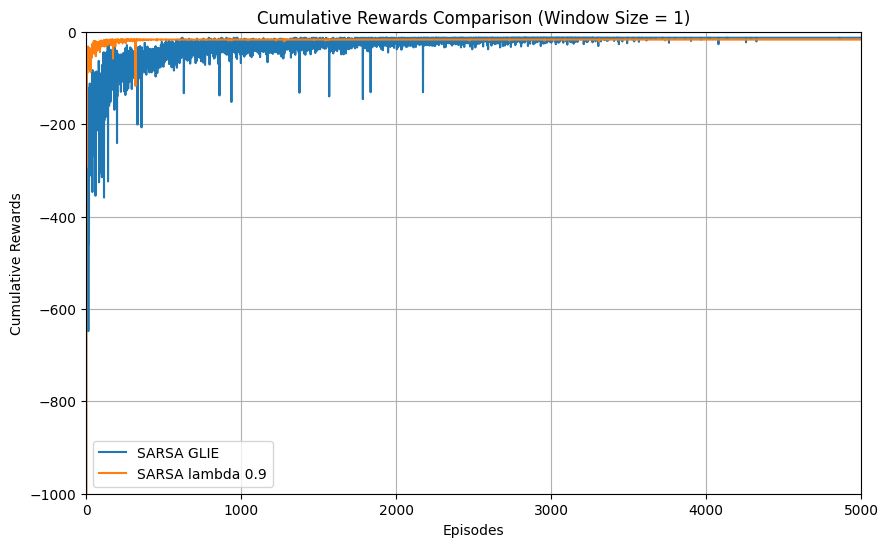

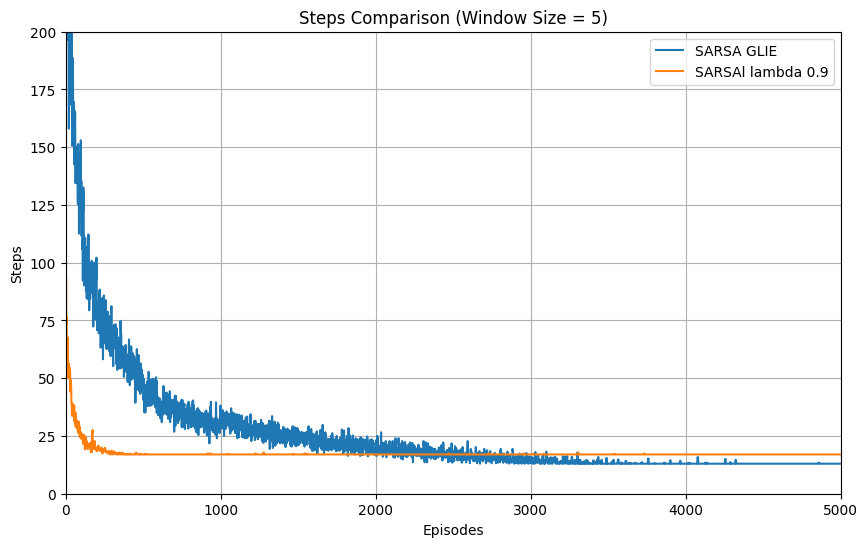

In [119]:
data_SARSA_reward2 = {
    'SARSA GLIE': rewards_SARSAg,
    'SARSA lambda 0.9': rewards_SARSAl,
}

data_SARSA_steps2 = {
    'SARSA GLIE': steps_SARSAg,
    'SARSAl lambda 0.9': steps_SARSAl,
}

plot_rewards(data_SARSA_reward2, x_limit=5000, window_size=1)
plot_steps(data_SARSA_steps2, x_limit=5000, window_size=5)

### Q-Learning

In [55]:
def QLearning(gamma=1, n_episodes=10000, alpha=0.01, epsilon_func=glie, targetQ=None):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    gamma = gamma
    alpha = alpha
    n_episodes = n_episodes
    total_steps = []
    total_rewards = []
    
    for i in range(n_episodes):
        state = env.reset()[0]  # (36, {'prob': 1})
        steps = 0
        cum_reward = 0
        
        epsilon = epsilon_func(i)
        
        while True:
            coin = random.random()
            if coin < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_state, reward, terminated, truncated, info = env.step(action)
            cum_reward += reward
            next_action = np.argmax(Q[next_state])
            
            if targetQ is not None:
                Q[state, action] = Q[state, action] + alpha*(reward + gamma*(targetQ[next_state, next_action])-Q[state, action])
            else:
                Q[state, action] = Q[state, action] + alpha*(reward + gamma*(Q[next_state, next_action])-Q[state, action])

            state = next_state
            steps += 1
            
            if terminated or truncated:
                break
        
        total_rewards.append(cum_reward)    
        total_steps.append(steps)
        total_steps.append(steps)  
                
    policy = np.argmax(Q, axis=1)

    return policy, Q, total_steps, total_rewards

In [57]:
policy_Q, Q_Q, steps_Q, rewards_Q = QLearning(n_episodes=5000, epsilon_func=eps_anneal(0.9,0.01,0.1))
print_policy(policy_Q)

↑ ↑ → → ↑ → → ↑ → ↓ ↓ ↓ 

→ → ↓ → → → → → → → → ↓ 

→ → → → → → → → → → → ↓ 

↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ 



In [58]:
policy_Qg, Q_Qg, steps_Qg, rewards_Qg = QLearning(n_episodes=5000)
print_policy(policy_Q)

↑ ↑ → → ↑ → → ↑ → ↓ ↓ ↓ 

→ → ↓ → → → → → → → → ↓ 

→ → → → → → → → → → → ↓ 

↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ 



In [64]:
policy_Qoff, Q_Qoff, steps_Qoff, rewards_Qoff = QLearning(n_episodes=5000, targetQ=Q_Qg)
print_policy(policy_Qoff)

← ↓ ↑ ↑ ↑ → → ↑ → ↑ ↓ ← 

→ ↓ ↑ → ↑ → → ↓ → ← ↑ ← 

→ → → → → → → → → → → ↓ 

↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ 



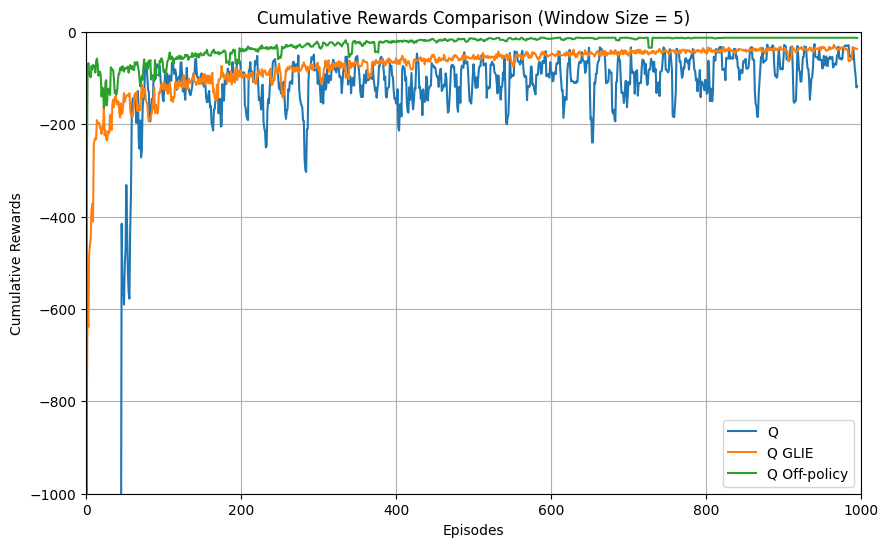

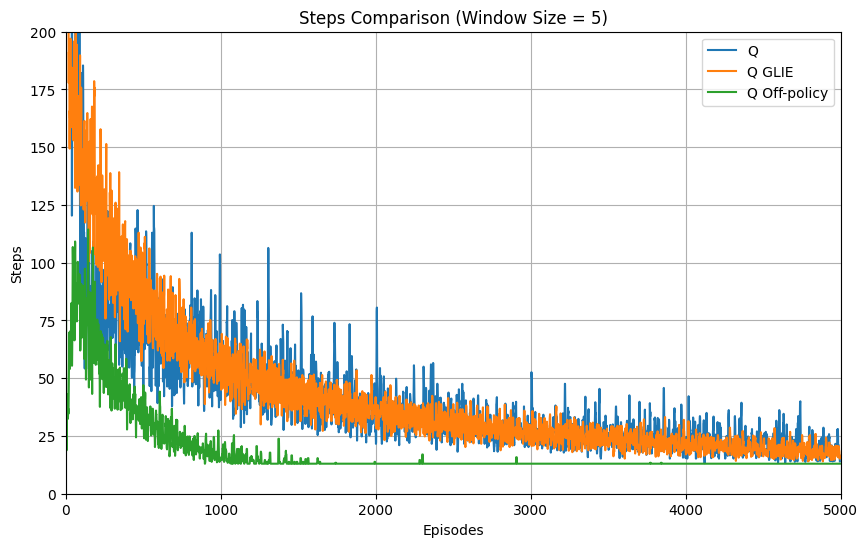

In [123]:
data_Q_reward = {
    'Q': rewards_Q,
    'Q GLIE': rewards_Qg,
    'Q Off-policy': rewards_Qoff,
}

data_Q_steps = {
    'Q': steps_Q,
    'Q GLIE': steps_Qg,
    'Q Off-policy': steps_Qoff,
}

plot_rewards(data_Q_reward, x_limit=1000, window_size=5)
plot_steps(data_Q_steps, x_limit=5000, window_size=5)


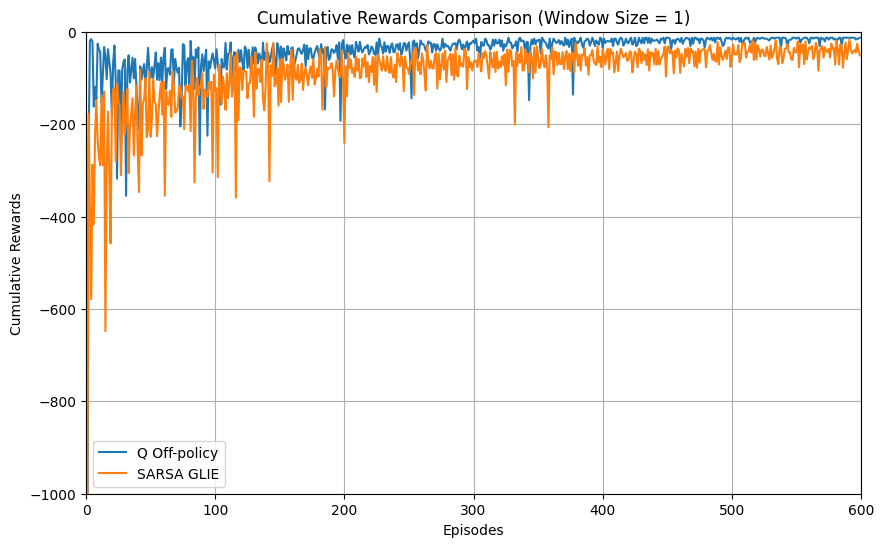

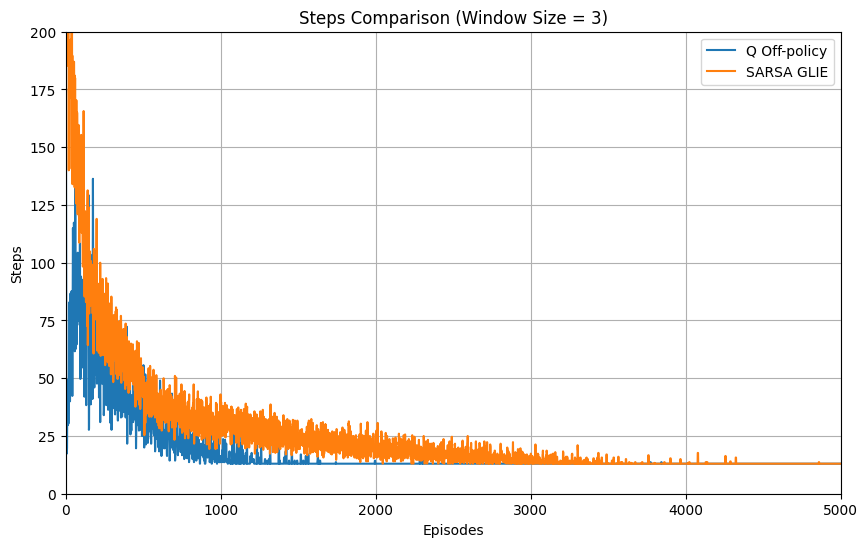

In [127]:
data_combined_reward = {
    'Q Off-policy': rewards_Qoff,
    # 'SARSA lambda 0.9': rewards_SARSAl,
    'SARSA GLIE': rewards_SARSAg
}

data_combined_steps = {
    'Q Off-policy': steps_Qoff,
    # 'SARSAllambda 0.9': steps_SARSAl,
    'SARSA GLIE': steps_SARSAg
}

plot_rewards(data_combined_reward, x_limit=600, window_size=1)
plot_steps(data_combined_steps, x_limit=5000, window_size=3)  # note steps is to 5000
